# **Table of contents**


1.   Load the data

2.   LDA: Sklearn Package

  *   Latent Dirichlet Allocation
  *   Hyper-parameters tuning
  *   NMF Method

3.   Gensim package: LDA

   *   Finding topics
   *   Tuning Hyper-parameters
   *   Analysing LDA results
      * Dominant Topic
      * topics distribution
      * most representative sentence 
      * WordClouds
      * pyLDAvis

   *   Testing on unseen documents

In [ ]:
import pandas as pd
import numpy as np
import re
import gensim
from gensim import models,corpora
from sklearn.decomposition import LatentDirichletAllocation,PCA
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from gensim.models import CoherenceModel
import tqdm

### Load the data

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/data.csv')

In [ ]:
data.dropna(inplace=True)

In [ ]:
data_nouns=pd.read_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/data_nouns.csv')

In [ ]:
data_nouns.dropna(inplace=True)

# **Topic assignment: Non-Supervised Methods** 

For this main part, we are going to use two different packages:

- **Sklearn package**: Latent Dirichlet allocation from the decomposition module

- **gensim package**: Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpus.

## Sklearn Package

for the Sklearn package we are going to deal with two methods:

- Latent Dirichlet Allocation:  the (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. In other words, we are looking to find hidden topics the dirichlet probabilistic distribution

### Latent Dirichlet Allocation

#### **Bag of words**

In [ ]:
tf_idf=TfidfVectorizer(stop_words='english')
title_counts=tf_idf.fit_transform(data['Title'])
bow_titles=pd.DataFrame(title_counts.todense(),columns=tf_idf.get_feature_names())
bow_titles.head()

,__await__,__builtin_ctz,__builtins__,__call__,__class__,__classcell__,__consumer_offsets,__dict__,__die__,__dirname,__func__,__future__,__getitem__,__init__,__macosx,__main__,__new__,__peg_parser__,__phello__,__typename,__va_args__,__wrapped__,_audio_microfrontend_op,_blank,_brew,_coalescedstylescheduler,_data,_generic,_get,_interoprequiredefault,_libs,_local,_native,_reactnative,_rotation_groups,_set,_shouldmakereadyfordevelopment,_thread,_traverse,_vm,...,yamls,yank,yarl,yarn,year,yellow,yes,yfinance,yield,yml,yogakit,yolo,youtube,youtube_dl,yoyo,yq,yup,yz,zeit,zeitwerk,zeppelin,zero,zeromq,zeros,zgc,zio,zip,zipcode,zmv,zone,zoneddatetime,zoom,zoomable,zoomtablemanager,zsh,zstack,zustand,zwj,ɵɵdefineinjectable,сonvert
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
number_topics = 5
# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics,verbose=1,learning_method='online',max_iter=10,learning_offset=50)
lda.fit(title_counts)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_idf.get_feature_names(), no_top_words)

Topic 0:
angular typescript import template vue type error operator laravel module
Topic 1:
native visualstudio click ios xcode npm exception pod promise route
Topic 2:
error flutter app use docker android component function build api
Topic 3:
value column array list string use function object data row
Topic 4:
spring memory load pointer boot library page const event deprecate


###tuning hyper-parameters

In [ ]:
params={'n_components':[5,10,15,20],
            'learning_decay':[0.5,0.7,0.9]}
base_estimator=LatentDirichletAllocation(verbose=1)
grid=GridSearchCV(estimator=base_estimator,param_grid=params,verbose=1)
grid.fit(title_counts)

In [ ]:
grid.best_params_

{'learning_decay': 0.5, 'n_components': 5}

In [ ]:
# Best Model
best_lda_model = grid.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(title_counts))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -53948.96230586646
Model Perplexity:  9145.02069616035


In [ ]:
best_lda_model.fit(title_counts)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(best_lda_model, tf_idf.get_feature_names(), no_top_words)

Topic 0:
spring file boot git use github table algorithm branch int
Topic 1:
value column list array string row use python dataframe data
Topic 2:
error app docker angular core flutter use css html page
Topic 3:
type function define use file typescript error java json javascript
Topic 4:
function type parameter use swiftui component error module python operator


### NMF Method

Another non-supervised method on modeling topics is the:

- **NMF**: Negative Matrix Factorisation

In [ ]:
#setting threshholds for nmf_vectorizer
nmf_vectorizer=TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english')
lines_vecttorized=nmf_vectorizer.fit_transform(data['Title'].values)

In [ ]:
lines_features=nmf_vectorizer.get_feature_names()

In [ ]:
#Run NMF
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(lines_vecttorized)

no_top_words = 10
display_topics(nmf, lines_features, no_top_words)

Topic 0:
use variable data dplyr api component test way cplusplus multiple
Topic 1:
column value dataframe row panda base rlang multiple data new
Topic 2:
array object javascript numpy value element key number index way
Topic 3:
function argument return parameter inside typeerror pass apply pointer pas
Topic 4:
list element item iterate create add way comprehension tuples nested
Topic 5:
error react file app flutter android build create fail work
Topic 6:
python dictionary import panda package key work install opencv loop
Topic 7:
type typescript parameter class generic return template method argument property
Topic 8:
string character convert extract word substring split number regex check
Topic 9:
java stream method lang class object record null code parallel


## Gensim package: LDA

- **Gensim**: gensim is a Python toolkit built by Radim Rehurek specifically for topic modeling 
- We are going to use a popular topic modeling technique called Latent Dirichlet Allocation (**LDA**) 
- We are also going to use nltk for some parts of text tagging 

### Finding topics

The two main inputs to the LDA topic model are:

- The dictionary(id2word)

- The corpus.

- list of the lines.

Let's create them


In [ ]:
def prepare_data(dt,feature,below,above):
  
  lines_list=[line.split() for line in dt[feature].values.tolist()]
  dict_lines = corpora.Dictionary(lines_list)
  dict_lines.filter_extremes(no_below=below,no_above=above)
  corpus = [dict_lines.doc2bow(line) for line in lines_list]

  #use the tf_idf transformer
  tf_idf=gensim.models.TfidfModel(corpus)
  final_corpus=tf_idf[corpus]

  return final_corpus,dict_lines,lines_list

In [ ]:
corpus,id_to_word,texts=prepare_data(data,'Title',15,0.5)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id_to_word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=2000,
                                       passes=20,
                                       per_word_topics=True)

In [ ]:
lda_model.print_topics()

[(0,
  '0.016*"file" + 0.015*"google" + 0.015*"api" + 0.013*"git" + 0.013*"page" + 0.012*"core" + 0.011*"aws" + 0.011*"container" + 0.011*"load" + 0.011*"use"'),
 (1,
  '0.026*"flutter" + 0.014*"android" + 0.014*"app" + 0.013*"fail" + 0.012*"custom" + 0.012*"ios" + 0.012*"image" + 0.012*"laravel" + 0.011*"docker" + 0.011*"error"'),
 (2,
  '0.033*"type" + 0.029*"function" + 0.023*"class" + 0.017*"method" + 0.017*"error" + 0.015*"parameter" + 0.012*"module" + 0.012*"cplusplus" + 0.012*"typescript" + 0.012*"object"'),
 (3,
  '0.030*"column" + 0.025*"value" + 0.023*"list" + 0.020*"string" + 0.018*"row" + 0.017*"data" + 0.016*"python" + 0.016*"rLang" + 0.016*"dataframe" + 0.016*"use"'),
 (4,
  '0.017*"array" + 0.016*"java" + 0.013*"json" + 0.013*"match" + 0.013*"package" + 0.012*"javascript" + 0.012*"object" + 0.012*"map" + 0.012*"result" + 0.012*"swiftui"')]

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=titles, dictionary=id_to_word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score:{}'.format(coherence_lda))

Coherence Score:0.3542625883789872


### Tuning Hyperparameters

Lets create a function, which creates the LDA model and then compute the **coherence_score** according to the hyperparameters provided 

In [ ]:
def coherence_score(data_corpus,data_dict,lines,k,a,b):

  lda=gensim.models.LdaMulticore(corpus=data_corpus,id2word=data_dict,
                             num_topics=k,alpha=a,
                             eta=b,chunksize=2000,
                             passes=5,per_word_topics=True)
  
  #coherence_score
  ch_score=CoherenceModel(model=lda,texts=lines,dictionary=data_dict,coherence='c_v')

  return ch_score.get_coherence()


We are going to iterate three hyperparameters: 

- **num_topics**: a set of topics between 10 and 30 

- **alpha**: Dirichlet hyperparameter alpha which is the Document-Topic Density we call it also the topic distribution parameter

- **eta**: Dirichlet hyperparameter beta which is the Word-Topic Density/word distribution parameter 

In [ ]:
#range of topics
topics=list(range(5,16,2))

#range of alpha
alphas=list(np.arange(0.01,1,0.3))
alphas.append('symmetric')
alphas.append('asymmetric')

#range of beta
betas=list(np.arange(0.01,1,0.3))
betas.append('symmetric')

#results
coherence_dict={'n_topics':[],
                'alphas_list':[],
                'betas_list':[],
                'coherence':[]}

#get_the_data
corpus,id_to_word,lines=prepare_data(data,'Title',below=15,above=0.5)

#hyper-parameter preparation
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
#iterate through the number of topics
    for topic in topics:
  #iterate through the topic density
      for alpha in alphas:
    #iterate through word-topic density
        for beta in betas:
          cm=coherence_score(data_corpus=corpus,data_dict=id_to_word,lines=lines,k=topic,a=alpha,b=beta)

          coherence_dict['n_topics'].append(topic)
          coherence_dict['alphas_list'].append(alpha)
          coherence_dict['betas_list'].append(beta)
          coherence_dict['coherence'].append(cm)
          pbar.update(1)

    pbar.close()

  0%|          | 0/540 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
 33%|███▎      | 180/540 [1:03:25<2:06:50, 21.14s/it]


In [ ]:
tuning_df=pd.DataFrame(coherence_dict)
tuning_df.head()

,n_topics,alphas_list,betas_list,coherence
0,5,0.01,0.01,0.281596
1,5,0.01,0.31,0.345001
2,5,0.01,0.61,0.297257
3,5,0.01,0.91,0.315458
4,5,0.01,symmetric,0.308249


In [ ]:
tuning_df['coherence'].idxmax()

160

In [ ]:
tuning_df.loc[160]

n_topics             15
alphas_list        0.61
betas_list         0.01
coherence      0.560867
Name: 160, dtype: object

In [ ]:
corpus,id_to_word,lines=prepare_data(data,'Title',below=15,above=0.5)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id_to_word,
                                       num_topics=15,
                                       alpha=0.61,
                                       eta=0.01, 
                                       random_state=100,
                                       chunksize=2000,
                                       passes=20,
                                       per_word_topics=False)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
lda_model.print_topics()

[(0,
  '0.069*"app" + 0.068*"android" + 0.047*"map" + 0.038*"server" + 0.033*"firebase" + 0.032*"query" + 0.030*"git" + 0.029*"aws" + 0.028*"error" + 0.027*"application"'),
 (1,
  '0.063*"return" + 0.056*"convert" + 0.047*"api" + 0.041*"build" + 0.040*"ios" + 0.037*"laravel" + 0.034*"user" + 0.034*"request" + 0.029*"connect" + 0.025*"state"'),
 (2,
  '0.104*"type" + 0.075*"class" + 0.035*"template" + 0.034*"spring" + 0.031*"typescript" + 0.031*"date" + 0.026*"parameter" + 0.025*"non" + 0.022*"dependency" + 0.022*"generic"'),
 (3,
  '0.097*"list" + 0.087*"string" + 0.064*"multiple" + 0.052*"two" + 0.051*"one" + 0.046*"different" + 0.030*"index" + 0.029*"within" + 0.027*"single" + 0.026*"replace"'),
 (4,
  '0.055*"number" + 0.044*"inside" + 0.044*"json" + 0.037*"get" + 0.034*"array" + 0.034*"possible" + 0.032*"sum" + 0.030*"clang" + 0.029*"operator" + 0.028*"instance"'),
 (5,
  '0.084*"data" + 0.055*"rLang" + 0.055*"element" + 0.055*"variable" + 0.042*"group" + 0.035*"line" + 0.031*"spec

#### main topics with only nouns

In [ ]:
corpus,id_to_word,lines=prepare_data(data_nouns,'Title',below=15,above=0.5)
lda_model_noun = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id_to_word,
                                       num_topics=15,
                                       alpha=0.61,
                                       eta=0.01, 
                                       random_state=100,
                                       chunksize=2000,
                                       passes=20,
                                       per_word_topics=True)
lda_model_noun.print_topics()

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


[(0,
  '0.090*"rLang" + 0.063*"package" + 0.055*"js" + 0.052*"git" + 0.046*"google" + 0.045*"server" + 0.045*"problem" + 0.040*"non" + 0.038*"sql" + 0.037*"html"'),
 (1,
  '0.108*"flutter" + 0.096*"string" + 0.084*"set" + 0.054*"date" + 0.051*"condition" + 0.049*"index" + 0.045*"filter" + 0.045*"color" + 0.044*"input" + 0.031*"exception"'),
 (2,
  '0.208*"value" + 0.143*"list" + 0.129*"type" + 0.063*"module" + 0.063*"parameter" + 0.036*"clang" + 0.032*"studio" + 0.029*"pas" + 0.025*"point" + 0.022*"space"'),
 (3,
  '0.166*"file" + 0.088*"image" + 0.078*"docker" + 0.056*"map" + 0.048*"table" + 0.043*"firebase" + 0.043*"size" + 0.042*"import" + 0.036*"django" + 0.036*"word"'),
 (4,
  '0.145*"array" + 0.132*"data" + 0.076*"two" + 0.049*"text" + 0.048*"std" + 0.045*"character" + 0.039*"sum" + 0.036*"memory" + 0.033*"match" + 0.031*"vector"'),
 (5,
  '0.236*"function" + 0.110*"element" + 0.069*"return" + 0.068*"version" + 0.042*"operator" + 0.039*"via" + 0.035*"member" + 0.029*"case" + 0.02

### Analysing LDA results

#### **Dominant topic and its percentage contribution in each document**

- First question that rises in our hands would be the **What is the Top dominant topic for each document**

- in **LDA models**, each document is composed of multiple topics. But, only one of them is dominant.

- the top topic will be assigned as the label for the sentence.

- The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

and so, we can see each document belong to which topic.

In [ ]:
def topic_contribution(model,corpus,texts):
  dt_dict={'dominant_topic':[],
           'topic_contribution':[],
           'keywords':[],
           'text':[]}
  for (doc_vec,doc) in zip(corpus,texts):    
    sorted_topics=sorted(model[doc_vec],key=lambda x: x[1],reverse=True)
    dt_dict['dominant_topic'].append(sorted_topics[0][0])
    dt_dict['topic_contribution'].append(sorted_topics[0][1])
    dt_dict['keywords'].append([word for (word,value) in model.show_topic(sorted_topics[0][0])])
    dt_dict['text'].append(doc)

  return pd.DataFrame(dt_dict,index=data.index)

In [ ]:
topic_contribution_dt=topic_contribution(lda_model,corpus,lines)

In [ ]:
topic_contribution_dt.head()

,dominant_topic,topic_contribution,keywords,text
0,9,0.122483,"[value, column, array, java, row, dataframe, s...","[initialize, use, constructor]"
1,12,0.122350,"[component, text, google, import, character, r...","[panda, json, valueerror, protocol, know]"
2,0,0.066667,"[app, android, map, server, error, firebase, q...","[cumsum, restarts]"
3,12,0.120914,"[component, text, google, import, character, r...","[pod, give, error, relate, ruby, gem, libffi]"
4,6,0.126249,"[module, package, load, issue, html, unable, p...","[zwj, sequence, valid]"


In [ ]:
topic_contribution_dt['dominant_topic'].value_counts()

9     897
0     803
5     736
3     724
6     683
2     680
8     658
13    650
1     632
12    626
14    604
7     590
10    589
4     567
11    561
Name: dominant_topic, dtype: int64

#### **the most discussed topics in the documents**




- Let’s compute the total number of documents attributed to each topic

- For that we are going to use the dataframe we exported above in order to get a count of each topic documents

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
def get_percentile(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
    plt.show()

def categorical_plot1(df,feature):
  feature_dt=df[feature].value_counts(ascending=False).head(20)
  plt.figure(figsize=(12,8))
  g=sns.countplot(feature,data=df,order=feature_dt.index.values)
  plt.xticks(rotation=70)
  get_percentile(g,df[feature])
  plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


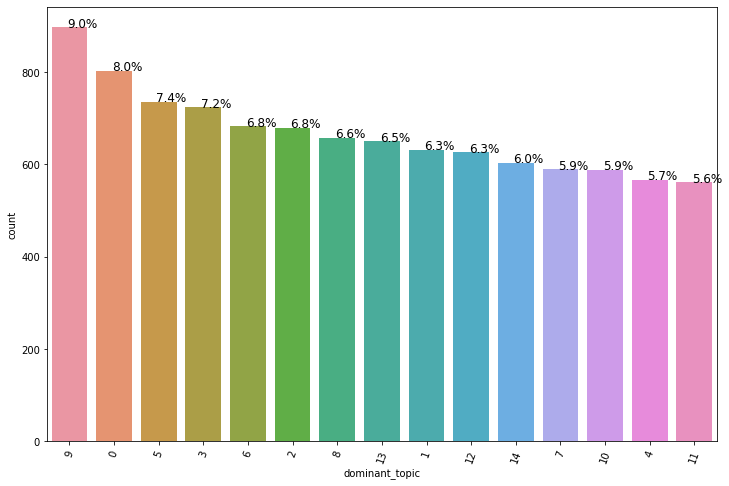

In [ ]:
categorical_plot1(topic_contribution_dt,'dominant_topic')

#### **The most representative sentence for each topic**

Next intresting question is: **What is, the most representative sentence for each topic?**

In order to see, what samples represents a given topic, the code below gets the most exemplar sentence for each topic.

In addition, the function displays **topic keywords** and its **contribution**

In [ ]:
topic_contribution_dt.head()

,dominant_topic,topic_contribution,keywords,text
0,9,0.122483,"[value, column, array, java, row, dataframe, s...","[initialize, use, constructor]"
1,12,0.122350,"[component, text, google, import, character, r...","[panda, json, valueerror, protocol, know]"
2,0,0.066667,"[app, android, map, server, error, firebase, q...","[cumsum, restarts]"
3,12,0.120914,"[component, text, google, import, character, r...","[pod, give, error, relate, ruby, gem, libffi]"
4,6,0.126249,"[module, package, load, issue, html, unable, p...","[zwj, sequence, valid]"


In [ ]:
def representive_sent(df):
  
  
  grouped_topics=df.groupby('dominant_topic')['topic_contribution'].max().reset_index()
  
  grouped_topics['Topic_keyword']=grouped_topics['dominant_topic'].apply(lambda x: ' '.join (word for (word,value) in lda_model.show_topic(x)))
  
  grouped_topics['representative_text']=grouped_topics['topic_contribution'].apply(lambda x: df.loc[(df['topic_contribution']==x),'text'].values.tolist()[0])
  
  grouped_topics.rename({'dominant_topic':'topic_num','topic_contribution':'topic_perc_contribution'},axis=1,inplace=True)
  
  return grouped_topics



In [ ]:
sent_contribution=representive_sent(topic_contribution_dt)
sent_contribution.head(15)

,topic_num,topic_perc_contribution,Topic_keyword,representative_text
0,0,0.233756,app android map server error firebase query git application background,"[springdoc, openapi, ui, honor, context, path, location]"
1,1,0.232362,return convert api build ios key laravel user request state,"[ionic, itms, deprecate, api, usage, ios]"
2,2,0.215025,type class template spring typescript date non dependency generic update,"[additional, dependency, logj, spring, boot]"
3,3,0.232183,list string multiple two one different index within single script,"[replace, multiple, forward, slash, directory, single, slash]"
4,4,0.233689,number inside json get possible sum clang operator instance thread,"[async, await, deadlock, cause, thread, sleep]"
5,5,0.240680,data rLang element variable group line specific item field input,"[point, line, specific, distance, axis, first, point]"
6,6,0.220412,module package load issue html unable project change aws native,"[error, unable, resolve, module, native, community, toolbar, android]"
7,7,0.232995,find table model stream core argument reference duplicate exception library,"[clean, architecture, asp, net, core, identity]"
8,8,0.222944,python function object base cplusplus order condition connect generate nest,"[pipe, sequence, function, python, pandas, filter, summarize, dplyr]"
9,9,0.246846,value column array java row dataframe set panda method null,"[panda, set, value, column, true, value, yes, subgroup, column]"


####**Word Clouds**

As far we have already seen what are the topic keywords in each topic.

However, a **word_cloud** with the size of the words proportional to the weight is a pleasant sight.

We used a white background color, so the words visualization could be better.

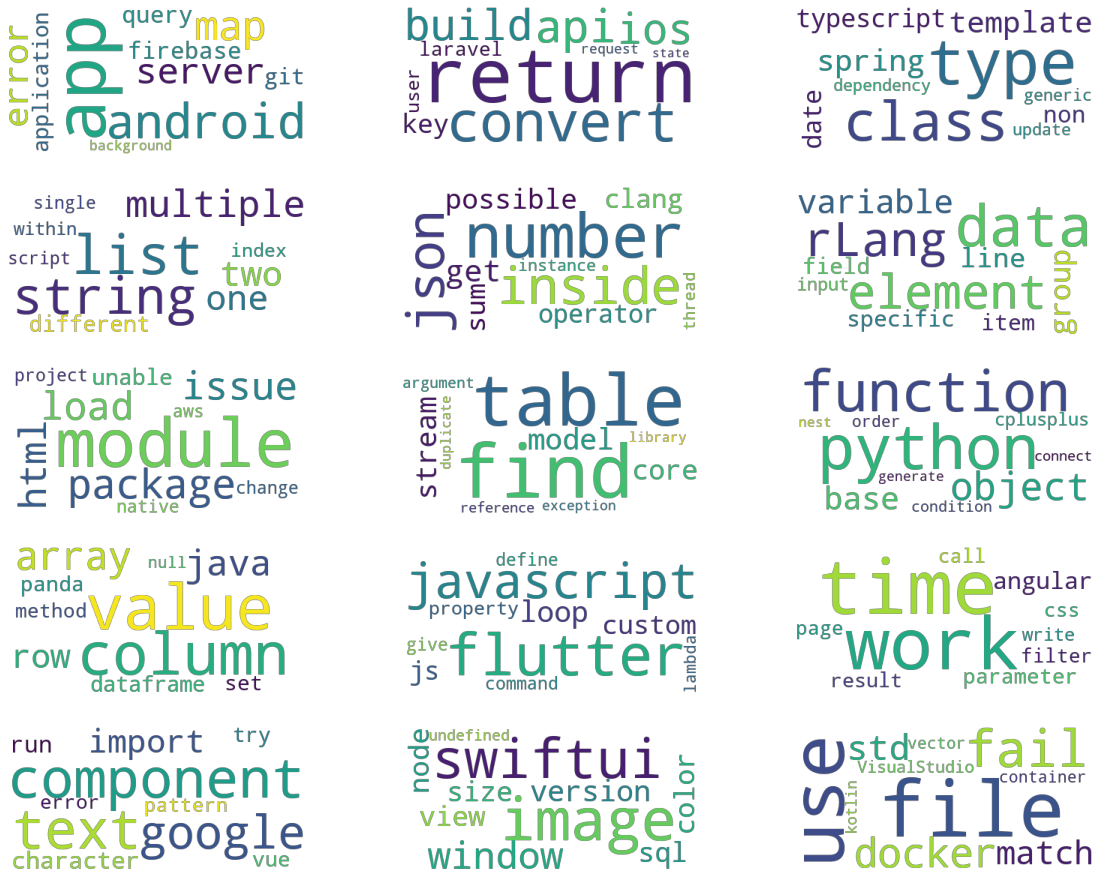

In [ ]:
#initialize the wordcloud object
from wordcloud import WordCloud
word_cloud=WordCloud(background_color=None,max_words=50,mode='RGBA')

#prepare the frequency data for wordclouds

term_freq={}
for i in range(0,15):
  term_freq[i]=dict(lda_model.show_topic(i))

#create the wordclouds for each topic
fig=plt.figure(figsize=(20,16))
for topic_num,topic_dict in term_freq.items():
  
  word_cloud.generate_from_frequencies(topic_dict)
  
  fig.add_subplot(5,3,topic_num+1)
  plt.imshow(word_cloud)
  plt.axis('off')

plt.show()

#### **pyLDAvis**

- Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. 

- in order to see the word counts in all documents and their use in each topic pyLDAvis could be helpful

In [ ]:
import pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id_to_word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.185528  0.140680       1        1  6.895927
1     -0.067174  0.253214       2        1  6.771175
5     -0.142181 -0.046488       3        1  6.737278
0      0.260052  0.021231       4        1  6.718726
6      0.154372  0.026061       5        1  6.704062
2     -0.035354 -0.116984       6        1  6.643447
8     -0.099538  0.004194       7        1  6.640327
12     0.154278  0.105853       8        1  6.633605
10    -0.084802 -0.202353       9        1  6.630343
3      0.010073  0.113873      10        1  6.624400
13     0.195306 -0.056829      11        1  6.619668
9      0.081044  0.006100      12        1  6.609401
4     -0.150191  0.048186      13        1  6.604759
7     -0.016214 -0.268601      14        1  6.590372
11    -0.074143 -0.028137      15        1  6.576510, topic_info=         Term        Freq       Total Category  logprob  loglift
11      array  149.000000  149.000000  Default  30.0000  30.0000
110      java  114.000000  114.000000  Default  29.0000  29.0000
52       find  110.000000  110.000000  Default  28.0000  28.0000
55     object  108.000000  108.000000  Default  27.0000  27.0000
125      work  105.000000  105.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
216  property   53.340148   53.850043  Topic15  -3.2254   2.7122
11      array  144.760334  149.929802  Topic15  -2.2270   2.6866
558    result   36.198484   43.137657  Topic15  -3.6131   2.5463
246   project   27.291071   40.339817  Topic15  -3.8956   2.3309
104       use   46.908558  282.820300  Topic15  -3.3539   0.9251

[589 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
150       3  0.098249  access
150       4  0.884245  access
150       6  0.019650  access
723      13  0.985071  across
663      11  0.981512  action
...     ...       ...     ...
125      14  0.009479    work
237       3  0.988714   write
457      12  0.983997   wrong
318       4  0.988094   xcode
761       3  0.973980     xml

[772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 6, 1, 7, 3, 9, 13, 11, 4, 14, 10, 5, 8, 12])

### testing on unseen document

In [ ]:
unseen_doc='prevent google colab disconnecting'

In [ ]:
unseen_vec=id_to_word.doc2bow(title_pipeline(unseen_doc).split())

In [ ]:
lda_model[unseen_vec]

([(0, 0.523447),
  (1, 0.014434167),
  (2, 0.0124008525),
  (3, 0.010869721),
  (11, 0.17369449),
  (14, 0.1635341)],
 [(6, [0]), (13, [0]), (429, [0]), (575, [11, 14, 0]), (9160, [14, 0, 11])],
 [(6, [(0, 0.9970677)]),
  (13, [(0, 0.9999328)]),
  (429, [(0, 0.99519163)]),
  (575, [(0, 0.011231673), (11, 0.9766011), (14, 0.012167166)]),
  (9160, [(0, 0.033784032), (11, 0.028977841), (14, 0.937238)])])

In [ ]:
for index, score in sorted(lda_multicore[tf_idf[unseen_vec]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.4672674834728241	 
Topic: 0.050*"How" + 0.021*"I" + 0.021*"file" + 0.019*"string" + 0.017*"use" + 0.010*"get" + 0.010*"line" + 0.009*"text" + 0.008*"Python" + 0.008*"character"

Score: 0.23596881330013275	 
Topic: 0.030*"value" + 0.029*"How" + 0.025*"column" + 0.020*"function" + 0.016*"use" + 0.013*"list" + 0.012*"row" + 0.012*"array" + 0.011*"variable" + 0.010*"type"

Score: 0.027266722172498703	 
Topic: 0.034*"How" + 0.020*"React" + 0.013*"use" + 0.012*"component" + 0.010*"work" + 0.010*"I" + 0.008*"update" + 0.006*"get" + 0.006*"state" + 0.006*"field"

Score: 0.02390001155436039	 
Topic: 0.011*"C" + 0.009*"version" + 0.008*"window" + 0.007*"The" + 0.007*"app" + 0.007*"Error" + 0.007*"size" + 0.006*"block" + 0.006*"Is" + 0.006*"run"

Score: 0.021273285150527954	 
Topic: 0.028*"array" + 0.017*"number" + 0.012*"x" + 0.009*"numpy" + 0.009*"many" + 0.008*"string" + 0.008*"error" + 0.007*"Julia" + 0.007*"Finding" + 0.007*"document"

Score: 0.019166812300682068	 
Topic: 0.009*"er